In [2]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from jia_modif import multi_regime, F, G, new_diagn, new_deaths, multi_regime_cidades
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

ModuleNotFoundError: No module named 'scipy.integrate'

In [1]:
from get_data import download_csv

download_csv()

### Sistema de Equações para a cidade A

$$
\begin{cases}
\frac{\mathrm{d}S_1}{\mathrm{d}t} &= -\beta_1 S_1\left(I_1 + \theta_1 A_1\right) - p_1 S_1 + \lambda_1 Q_1 - \mu_1 S_1 + \mu_2 S_2\\
\frac{\mathrm{d}Q_1}{\mathrm{d}t} &= p_1 S_1 - \lambda_1 Q_1\\
\frac{\mathrm{d}E_1}{\mathrm{d}t} &= \beta_1 S_1(I_1 + \theta_1 A_1) - \sigma_1 E_1 - \mu_1 E_1 + \mu_2 E_2\\
\frac{\mathrm{d}A_1}{\mathrm{d}t} &= \sigma_1(1- \rho_1)E_1 - \epsilon_{A_1} A_1 - \gamma_{A_1} A_1 - \mu_1 A_1 + \mu_2 A_2\\
\frac{\mathrm{d}I_1}{\mathrm{d}t} &= \sigma_1\rho_1 E_1 - \epsilon_{I_1} I_1 - \gamma_{D_1} D_1 - d_{D_1} D_1 - \delta_1 I_1 + \delta_2 I_2\\\
\frac{\mathrm{d}R_1}{\mathrm{d}t} &= \gamma_{A_1} A_1 + \gamma_{I_1} I_1 + \gamma_{D_1} D_1  - \mu_1 R_1 + \mu_2 R_2
\end{cases}
$$
---
### Sistema de Equações para a Cidade B

$$
\begin{cases}
\frac{\mathrm{d}S_2}{\mathrm{d}t} &= -\beta_2 S_2\left(I_2 + \theta_2 A_2\right) - p_2 S_2 + \lambda_2 Q_2 - \mu_2 S_2 + \mu_1 S_1\\
\frac{\mathrm{d}Q_2}{\mathrm{d}t} &= p_2 S_2 - \lambda_2 Q_2\\
\frac{\mathrm{d}E_2}{\mathrm{d}t} &= \beta_2 S_2(I_2 + \theta_2 A_2) - \sigma_2 E_2 - \mu_2 E_2 + \mu_1 E_1\\
\frac{\mathrm{d}A_2}{\mathrm{d}t} &= \sigma_2(1- \rho_2)E_2 - \epsilon_{A_2} A_2 - \gamma_{A_2} A_2 - \mu_2 A_2 + \mu_1 A_1\\
\frac{\mathrm{d}I_2}{\mathrm{d}t} &= \sigma_2\rho_2 E_2 - \epsilon_{I_2} I_2 - \gamma_{D_2} D_2 - d_{D_2} D_2 - \delta_2 I_2 + \delta_1 I_1\\
\frac{\mathrm{d}R_1}{\mathrm{d}t} &= \gamma_{A_1} A_1 + \gamma_{I_1} I_1 + \gamma_{D_1} D_1 - \mu_2 R_2 + \mu_1 R_1
\end{cases}
$$

In [2]:
# Taxa de subnotificação
taxa_subn   = 8
prop_assint = 0.80

In [3]:
# Dados para a cidade do Rio de Janeiro,
# IBGE 2019 (estimativa)
pop_Rio = 6718903
# 29 de Março
diagn_Rio, recup_Rio = 489, 16
infect_Rio = diagn_Rio*(taxa_subn-1)*(1 - prop_assint)
assint_Rio = diagn_Rio*(taxa_subn-1)*prop_assint
expostos_Rio = diagn_Rio*7
quarentena_Rio = 0.6 * pop_Rio

sucetiveis_Rio = pop_Rio - (quarentena_Rio + expostos_Rio + assint_Rio + infect_Rio + diagn_Rio + recup_Rio)

In [4]:
# Dados para a cidade do ????,
# IBGE 2019 (estimativa)
pop_Cid = 6718903
# 29 de Março
diagn_Cid, recup_Cid = 489, 16
infect_Cid = diagn_Cid*(taxa_subn-1)*(1 - prop_assint)
assint_Cid = diagn_Cid*(taxa_subn-1)*prop_assint
expostos_Cid = diagn_Cid*7
quarentena_Cid = 0.6 * pop_Cid

sucetiveis_Cid = pop_Cid- (quarentena_Cid + expostos_Cid + assint_Cid + infect_Cid + diagn_Cid + recup_Cid)

In [5]:
CI_rio = [sucetiveis_Rio, quarentena_Rio, expostos_Rio, assint_Rio, infect_Rio, diagn_Rio, recup_Rio]
CI_cid = [sucetiveis_Cid, quarentena_Cid, expostos_Cid, assint_Cid, infect_Cid, diagn_Cid, recup_Cid]
#CI = [(i,j) for i,j in zip(CI_rio, CI_cid)]
CI = CI_rio + CI_cid
#CI = CI_rio + CI_rio

## Problema

$\mu$ não pode assumir valor $> 0.7$, ele para a solução antes do tempo 
quanto maior o valor, mais cedo para a solução

In [6]:
# Idx       :         0,    1,   2,      3,     4,    5,     6,      7,    8,      9,     10,     11,     12  13  14
# Parâmetros:      beta,  phi,   p, lambda, sigma, theta,  epsA, gammaA, epsI, gammaI, deathI, gammaD, deathD  mu  delta
params_rio_base = (1e-7, 1/10, 1/4,    1/6,   1/7, 0.94, 1/100, 0.0996, 1/30, 0.0766, 0.0026, 0.0843, 0.0017, .2, 0.2)

# Idx       :         0,    1,   2,      3,     4,    5,     6,      7,    8,      9,     10,     11,     12  13  14
# Parâmetros:      beta,  phi,   p, lambda, sigma, theta,  epsA, gammaA, epsI, gammaI, deathI, gammaD, deathD  mu delta
params_cid_base = (1e-7, 1/10, 1/4,    1/6,   1/7, 0.94, 1/100, 0.0996, 1/30, 0.0766, 0.0026, 0.0843, 0.0017, 0.2, 0.3)
params = [(i,j) for i,j in zip(params_rio_base, params_cid_base)]

In [7]:
dados_Rio = [
    [26, 38, 30, 114, 110, 60, 115, 86, 42, 141, 198, 184, 175, 97, 91, 326, 71, 126, 140, 160, 180, 200],
    [1,   3,  2,   4,   7,  5,   2,  4,  5,  12,  14,   9,  10,  6,  8,   9, 25,  27,  28, 40,50,60 ]
]

In [8]:
dados_Cid = [ 
    [5, 16, 23, 44, 71, 90, 105, 56, 97, 122, 106, 109, 107, 97, 125, 144, 98, 65, 122,300,350,400],
    [0,  1,  1,  3,  4,  5,   2,  3,  4,   8,  11,   7,   9, 12,   8,  13, 15, 20,  18,80,90,100]
] #ficticioi

In [9]:
T_fim = len(dados_Rio[0])

start = dt.datetime.strptime("29-03-2020", "%d-%m-%Y")
then = start + dt.timedelta(days=T_fim)
days = mdates.drange(start,then,dt.timedelta(days=1))

In [10]:
# Supondo mantida a quarentena
f_rio_base = lambda t,v: G(t,v, params)
results_base = solve_ivp(f_rio_base, (1,T_fim), CI, t_eval=range(1,T_fim+1), method = 'RK45')

In [11]:
diagn = new_diagn(results_base.y, params)

In [12]:
results_base.message

'The solver successfully reached the end of the integration interval.'

In [13]:
#len(diagn[0]), len(diagn[1])

Text(0.5, 1.0, 'Novos diagnósticos')

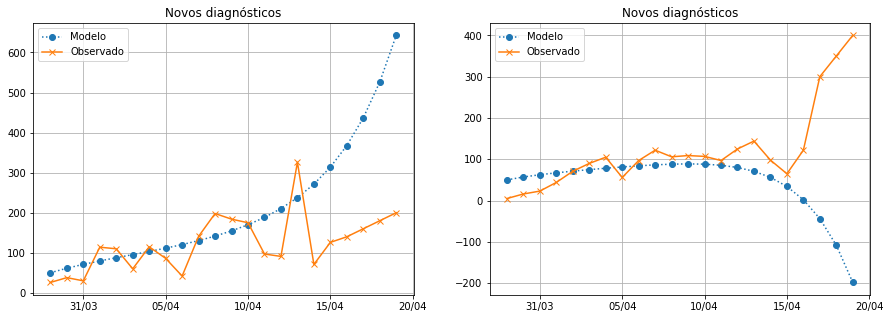

In [14]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,5))

#diagn = new_diagn(results_base.y, params_rio_base)
ax1.plot(days, diagn[0],        'o:', label='Modelo')
ax1.plot(days, dados_Rio[0], 'x-', label='Observado')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax1.grid()
ax1.legend()
ax1.set_title('Novos diagnósticos')

#diagn = new_diagn(results_base.y, params_rio_base)
ax2.plot(days, diagn[1],        'o:', label='Modelo')
ax2.plot(days, dados_Cid[0], 'x-', label='Observado')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax2.grid()
ax2.legend()
ax2.set_title('Novos diagnósticos')

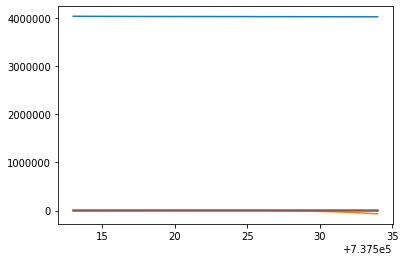

In [15]:
for i in range(8,14):
    plt.plot(days, results_base.y[i])

In [16]:
c = 0
for i in range(14):
    c+=results_base.y[i][18]

13437480.528702259


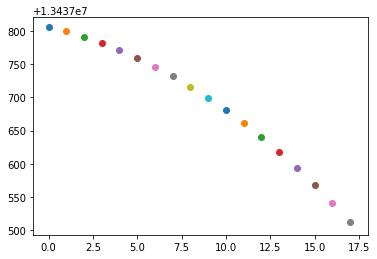

In [17]:
print(c)
for i in range(18):
    plt.scatter(i,np.sum(results_base.y[:,i]))

In [18]:
def tot_deaths(res):
    return np.sum(res[:,0]) - np.sum(res, axis=0)

In [19]:
p1 = params[:]
p1[-1][0],p1[-1][1],p1[-2][0],p1[-2][1] = 0,0,0,0

t_par_lst = [(10,params),(25,p1),(35,params)]

ss = multi_regime_cidades(CI, 0, t_par_lst)

TypeError: 'tuple' object does not support item assignment

In [ ]:
# plt.plot(ss[:,4])

plt.plot(ss[0])
plt.plot(ss[7])

In [ ]:
for i in range(7):
    print(ss[i] == ss[i+7])

In [ ]:
CI